## Welcome to Algosoc, the soceity for algorithmic trading and quantitative finance at Imperial

### Who are we

We are founded in March 2018 with the aim to provide education and networking opportunities for students interested in algorithmic trading and quantitative finance. In 2018 and 2019 we organise the Algothon with Blackrock which is the flagship event of our soceity. Algothon 2020 was cancelled this year due to covid-19. Algothon 2021 was held online with Aspect Capital. 

http://www.algosoc.com/

#### Lecture 1: Understanding financial data

#### Price data


The most basic data to be dealt with in quantitative finance is price data, which represent how much a financial asset is worth at a given time. Traditionally (1990s), time series models such as ARIMA model are used widely in trading to capture trends in the market. Recently, the focus has moved to using deep learning models such as LSTM and CNN to learn more complicated behaviour.

https://reference.wolfram.com/language/ref/ARIMAProcess.html    
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM    

Price data is determined by two charactereistics, frequency of data and types of data. Frequency of data can ranged from microseconds data (tick level) to end-of-date data (daily resolution). We will focus on data that have a minute resoluion or above. Major types of data include bar data, trade data and quote data.

In an exchange, quote data (Orderbook) is displayed for a stock in real time which has the bid and ask price (with size) submitted by different market participants. A trade is made if someone is willing the buy the security at the ask price (or sell the security at the bid price). Bar data is then aggregrated using the trade price and volume over an interval, which usually is a minute, an hour and a day.

https://iextrading.com/apps/tops/

In this notebook, we will illustrate various basic concepts in finance using the most famous ETF, SPDR S&P 500 (SPY) which keep tracks of the most important stock market index S&P 500 in the world. This ETF invest in the 500 biggest stocks listed in the US, weighted by market-cap. 

In [3]:
! pip install yfinance

     |████████████████████████████████| 6.3 MB 6.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=18c17d68f8b75ea7f852148acfba5bf2661309e44c0bfe440696371ebc6f6499
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd

In [ ]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")

A typical bar data would include Open, High, Low, Close and Volume within a time period, which is a trading day in the following example. As stocks can pay dividend and have splits, we usually use adjusted price to perform statistical analysis. From the adjusted price, we can derive the total return of the stock (which is the sum of price return and dividends, reinvested). 



In [ ]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-28,439.690002,440.040009,432.940002,433.720001,130436300,0.0,0
2021-09-29,435.190002,437.040009,433.850006,434.450012,82329200,0.0,0
2021-09-30,436.019989,436.769989,428.779999,429.140015,140181200,0.0,0
2021-10-01,430.980011,436.029999,427.230011,434.239990,129240100,0.0,0
2021-10-04,433.000000,433.959991,426.359985,428.640015,128430500,0.0,0


Stock price are not stationary as they tend to grow over time. (Exception: Japanese stock market). 

For building models, it is better to use the log-return instead. Log-return is better than percentage return since it is additive over different time periods. 

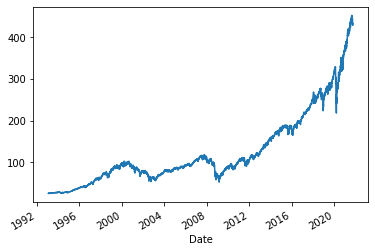

In [ ]:
hist['Close'].plot()

In [ ]:
## Calculating log-returns
hist['log_return'] = np.log(hist['Close']) - np.log(hist['Close'].shift(1))

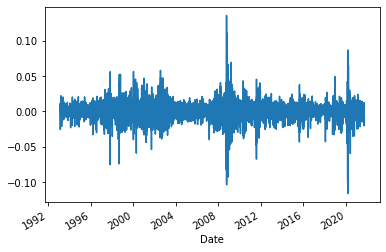

In [ ]:
hist['log_return'].plot()

Statistical properties of stock market log-returns 

It has a positive mean, which is bigger than the average 10-year Treasury yield. This is called the risk premium of equity market

It has a negative skew, which demonstrates the fact the stock market experiences sharp drawdowns over a short period (2008,2020) 

It has a kurtosis greater than 3, suggesting it is more fat-tail than a normal distribution. 

The assumption of log-return following Gaussian distribution, as Brownian motion is the fundation of Black-Scholes Option pricing model. 

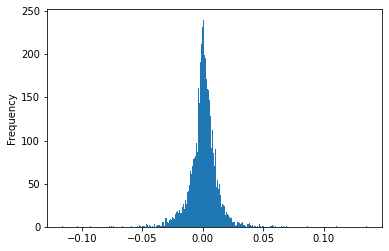

In [ ]:
hist['log_return'].plot.hist(bins=500)

In [ ]:
hist['log_return'].describe()

count    7222.000000
mean        0.000390
std         0.011825
min        -0.115886
25%        -0.004288
50%         0.000681
75%         0.005859
max         0.135578
Name: log_return, dtype: float64

In [ ]:
hist['log_return'].skew()

-0.2996344311157923

In [ ]:
hist['log_return'].kurtosis()

11.78171968286361

## Different measures of return 

We can separate the return of stock market into two parts. One as the close-to-open return (overnight return) and open-to-close return (intraday return) 

We can see intraday return has a mean close to zero, suggesting the mean-reversion nature of stock price during market hours. 

Most of the stock market return, for a buy-and-hold strategy in the long run, comes from holding stocks overnight. This can be considered as compensation of the risk to hold stocks overnight. 



In [ ]:
hist['intraday_return'] = np.log(hist['Close']) - np.log(hist['Open'])
hist['overnight_return'] = np.log(hist['Open']) - np.log(hist['Close'].shift(1))

In [ ]:
hist['intraday_return'].describe()

count    7223.000000
mean       -0.000007
std         0.009651
min        -0.094207
25%        -0.004140
50%         0.000427
75%         0.004580
max         0.088892
Name: intraday_return, dtype: float64

In [ ]:
hist['overnight_return'].describe()

count    7222.000000
mean        0.000396
std         0.006729
min        -0.110357
25%        -0.002052
50%         0.000623
75%         0.003208
max         0.059519
Name: overnight_return, dtype: float64

### Volatility Scaling

We can measure the performance of a trading strategy by the sharpe ratio, which is ratio of excess return over to the volatility. 

Sharpe_Ratio = $\frac{r-r_f}{\sigma}$, where r is the return of the portfolio and $\sigma$ the standard deviation of the return of the portfolio. 

Volatility is detrimental to the long-term growth of capital as a strategy down 20% needs a 25% growth to recover. 

By adjusting our holdings of stock to constant volatility, so that we buy more during low volatility times and buy less during high volatility times. The Sharpe ratio can be improved compared to a constant buy-and-hold strategy.

Volatility plays an important role in portfolio construction and risk management. Risk parity, a famous hedge fund strategy aims to hold constant volatility exposure to different assets in the portfolio, rather than equal weighted. Banks are required to report their inventory risk at the end of time using VaR (Value at Risk) measures. 



In [ ]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

In [ ]:
# Weight portfolio by comparing the current 3-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

In [ ]:
hist['return'].mean() / hist['return'].std()

0.038933253086714165

In [ ]:
## Improvement of Sharpe ratio of constant vol strategy 
hist['vol_adj_return'].mean() / hist['vol_adj_return'].std()

0.05387732991872466

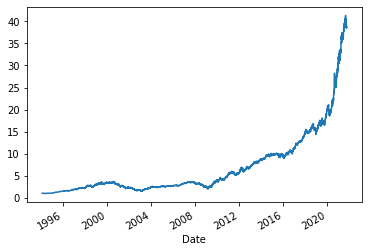

In [ ]:
(1+hist['vol_adj_return']).cumprod().plot()

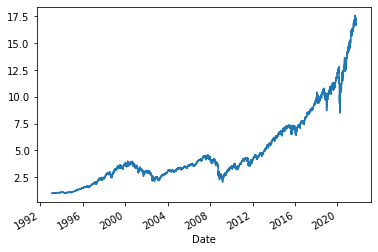

In [ ]:
(1+hist['return']).cumprod().plot()

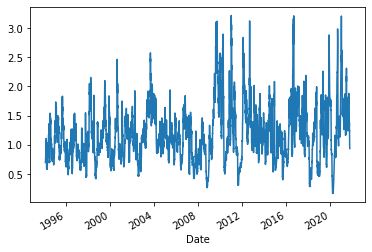

In [ ]:
hist['vol_port_size'].plot()

To carry out the above volatility adjusted strategy, you need to have access to leverage (up to 3x). 

In [ ]:
selected_etf = yf.Ticker("EEM")
hist = selected_etf.history(period="max")

In [ ]:
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

# Weight portfolio by comparing the current 3-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

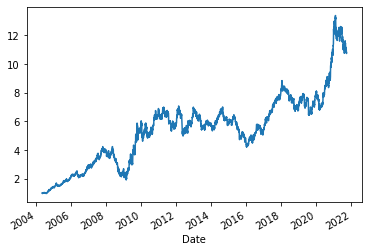

In [ ]:
(1+hist['vol_adj_return']).cumprod().plot()

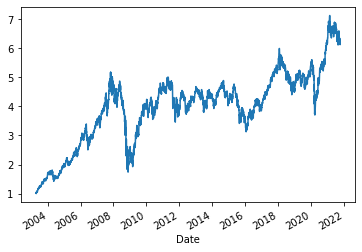

In [ ]:
(1+hist['return']).cumprod().plot()

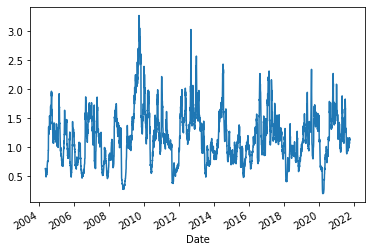

In [ ]:
hist['vol_port_size'].plot()

The above strategy also applies to EM stock market. As long as the ETF will generate positive return in the long run, volatility scaling can improve sharpe ratio and return of strategy. 


## Recommended readings 

- Algorithmic Trading: Winning Strategies and Their Rationale, Ernest P. Chan

- Advances in Financial Machine Learning, Marcos López de Prado

- A Complete Guide to the Futures Market: Technical Analysis, Trading Systems, Fundamental Analysis, Options, Spreads, and Trading Principles (Wiley Trading), Jack D. Schwager

## Lecture 2 Volatility 

Volatility in portfolio is undesirable since they erode long term return of the portfolio. Investors are looking for ways to reduce portfolio volatility. For asset managers, holding government bonds and derivatives are common means to hedge against equity holdings they have.

Without formally introducing the concept of options (where we might do in later lectures), we will introduce the concept of a put option as an insurance policy. From this perspective, asset managers might buy put options (in reality put spreads or other more sophiscated strategies) to reduce drawdown in portfolio during market distress. 

The benefit of reducing drawdown and thus volatility in portfolio is that it allows rebalancing after market crash. Investors can sell their bonds or put options to buy cheap stocks. 

In this lecture, we will show that the buy-and-hold strategy is inherent a short volatility strategy, which means it benefits when market volatility is falling.  


In [11]:
## VIX index, the fear gauge of the global equity market 
selected_etf = yf.Ticker("^VIX")

In [12]:
vixhist = selected_etf.history(period="max")

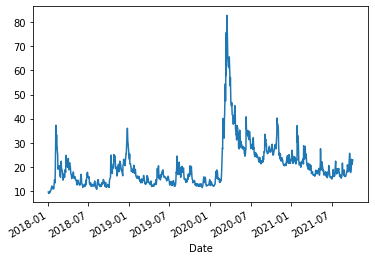

In [ ]:
vixhist['Close'].loc['2018-01-01':].plot()

It is not possible to invest in VIX directly. There are volatility ETFs which keep tracks of the VIX Futures, where traders buy and sell to express their views on market volatility. VXX is an example of volatility ETF that are widely traded by retail.  

Due to rollover costs, VXX will generate a much worse return than VIX.


A crucial feature is that holding VIX futures, and similarly buying Put Options on SPY generates a negative return in the long run.

Considering the correlation between VXX (Long volatility) and SH (Short SPY) we conclude the long volatility strategies are inherently shorting the market. 

Assuming we can short VXX (that is short volatility) without additional borrowing cost, it will have a high correlation with the market return (long SPY). This is why we call buy-and-hold equity as inherenetly a short volatility strategy. 

Since buy-and-hold VXX will simply cancels the return from holding SPY, therefore VXX alone is not a good portfolio hedge. 




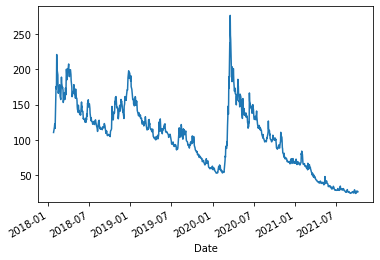

In [ ]:
selected_etf = yf.Ticker("VXX")
vxxhist = selected_etf.history(period="max")
vxxhist['Close'].loc['2018-01-01':].plot()

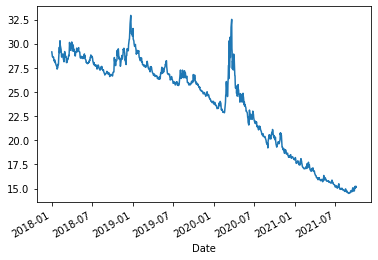

In [ ]:
selected_etf = yf.Ticker("SH")
shhist = selected_etf.history(period="max")
shhist['Close'].loc['2018-01-01':].plot()

In [ ]:
## Very high correlation between long volatility (UVXY) and short equity (SH) 
np.corrcoef(shhist['Close'].loc['2020-01-01':],vxxhist['Close'].loc['2020-01-01':])[0,1]

0.862606495929021

There are more than one kind of volatility ETFs

VXX keep track of the S&P 500 VIX Short-Term Futures Index Total Return
VXZ keep track of S&P 500 VIX Mid-Term Futures Index.

VXZ has a less significant contango effect than VXX, but keep track of the spot VIX less well. 

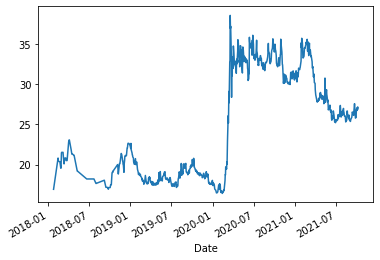

In [ ]:
selected_etf = yf.Ticker("VXZ")
vxzhist = selected_etf.history(period="max")
vxzhist['Close'].loc['2018-01-01':].plot()

In the following lectures we will introduce different strategy that aims to reduce portfolio drawdown during market drawdowns 

- Commodities Trend Following (Uncorrelated return during demand and supply shocks)
- Risk Parity (Leveraged bets on interest rates going down)
- Active Long Volatility (Time when to buy call/put options)



Regime switch model on SPY 

In [31]:
! pip install hmmlearn

     |████████████████████████████████| 374 kB 8.4 MB/s 


In [108]:
from hmmlearn.hmm import GaussianHMM

selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max")
spyhist['Return'] = spyhist['Close'].pct_change()
trainrets = spyhist.loc['1996-01-01':'2015-01-01']
testrets = spyhist.loc['2018-01-01':'2022-01-01']

In [97]:
hmm_model = GaussianHMM(
        n_components=2, covariance_type="full", n_iter=1000
    ).fit(trainrets['Return'].values.reshape(-1, 1))


In [109]:

testrets['State'] = hmm_model.predict(testrets['Return'].values.reshape(-1, 1))
testrets['Filtered'] = testrets['State'] * testrets['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


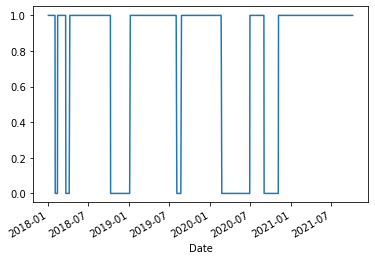

In [110]:
testrets['State'].loc['2018-01-01':].plot()

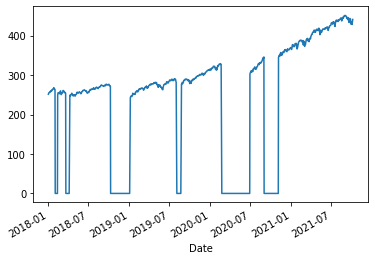

In [111]:
testrets['Filtered'].loc['2018-01-01':].plot()

In [112]:
## State 0 is bear market  
## State 1 is bull market 
testrets.groupby('State').mean()['Return']

State
0   -0.001177
1    0.001278
Name: Return, dtype: float64

In [113]:
testrets.groupby('State').std()['Return']

State
0    0.024239
1    0.006979
Name: Return, dtype: float64

Can we obtain a similar model by cosidering the value of VIX? 

In [9]:
selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
selected_etf = yf.Ticker("^VIX")
vixhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
spyhist['Return'] = spyhist['Close'].pct_change()
spyhist['VIX'] = vixhist['Close']
spyhist['VIX_State'] = np.where(spyhist['VIX']<25,1,0)
trainrets = spyhist.loc['1996-01-01':'2015-01-01']
testrets = spyhist.loc['2018-01-01':'2022-01-01']

In [11]:
testrets.groupby('VIX_State').mean()['Return']

VIX_State
0   -0.001212
1    0.001148
Name: Return, dtype: float64

In [12]:
testrets.groupby('VIX_State').std()['Return']

VIX_State
0    0.025344
1    0.007969
Name: Return, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


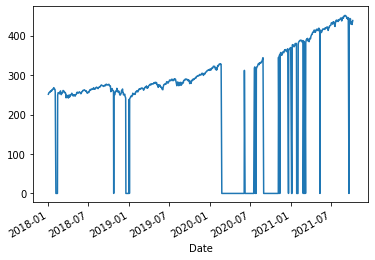

In [14]:
testrets['Filtered'] = testrets['Close'] * testrets['VIX_State']
testrets['Filtered'].loc['2018-01-01':].plot()

Splitting the test period by the value of VIX provides a similar model as HMM. However states learned by HMM are more continuous.

We have demonstrated the volatility clustering behaviour of stock price.

#### Recommended readings 

- GMO Research (Value investor that holds perma-bear views?) 
- https://www.gmo.com/europe/research-library/part-2-what-to-do-in-the-case-of-sustained-inflation/   

- JP Morgan Collar Trade (A very famous hedged equity trade that are monitored by traders in volatility due to its size and market impact)
- https://www.sec.gov/Archives/edgar/data/1217286/000119312514204872/d730531d497k.htm
- https://www.youtube.com/watch?v=qpkbvoRH7Lc





### Lecture 3 Portfolio Optimisation 

We will introduce the classical portfolio of 60/40 and the classic mean-variance portfolio optimisation methods. 



In [ ]:
selected_etf = yf.Ticker("TLT")
tlthist = selected_etf.history(period="max")
selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max")

In [ ]:
tlthist['return'] = tlthist['Close'].loc['2005-01-01':].pct_change()
spyhist['return'] = spyhist['Close'].loc['2005-01-01':].pct_change()

In [ ]:
# 60/40 portfolio 
classic = 0.6 * spyhist['return'] + 0.4 * tlthist['return']
classic = classic.dropna()

In [ ]:
portfolio_classic = (1 + classic).cumprod()

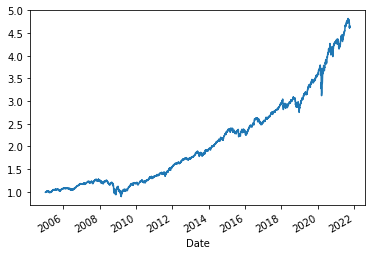

In [ ]:
portfolio_classic.plot()

In [ ]:
classic.mean() / classic.std()

0.0577801675457562

The sharpe ratio of 60/40 portfolio is better than the buy and hold portfolio and volatility-scaled portfolio of SPY. Over the last 20 years, bond is a successful hedge for stocks. 


In [ ]:
! pip install PyPortfolioOpt

     |████████████████████████████████| 60 kB 2.1 MB/s 
     |████████████████████████████████| 2.7 MB 10.3 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

We will demonstrate a very basic example of Mean-variance optimization using different stocks and bonds ETF

In [ ]:
prices = list()

ETF_list = ['SPY','QQQ','EWU','TLT','LQD','EEM']

for ETF in ETF_list :
    selected_etf = yf.Ticker(ETF)
    etfhist = selected_etf.history(period="max")
    prices.append(etfhist['Close'].loc['2005-01-01':])

In [ ]:
merged_prices = pd.DataFrame(pd.concat(prices,axis=1))
merged_prices.columns = ETF_list

In [ ]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(merged_prices)
S = CovarianceShrinkage(merged_prices).ledoit_wolf()

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [ ]:
cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('SPY', 0.0),
             ('QQQ', 0.46859),
             ('EWU', 0.0),
             ('TLT', 0.49571),
             ('LQD', 0.0357),
             ('EEM', 0.0)])

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 10.3%
Annual volatility: 10.1%
Sharpe Ratio: 0.83


(0.10331833940690184, 0.10050189977926681, 0.8290225318117829)

Lets use a different portfolio optimisation method, Hierarchical Risk Parity (HRP) portfolio.

Risk Parity portfolio tends to overweights bonds (LQD,TLT).

In [ ]:
from pypfopt.hierarchical_portfolio import HRPOpt

In [ ]:
ef = HRPOpt(merged_prices.pct_change(), S)

In [ ]:
ef.optimize()

OrderedDict([('EEM', 0.036998581975009576),
             ('EWU', 0.03142927658589791),
             ('LQD', 0.563857499030923),
             ('QQQ', 0.12317205377822954),
             ('SPY', 0.046660406258609906),
             ('TLT', 0.19788218237132998)])

In [ ]:
ef.portfolio_performance()

(0.07584490584254756, 0.07950358115875131, 0.7024200045912079)

We can also change the optimisation criteria for Efficiet Frontier to penalise downside volatility only

In [ ]:
from pypfopt import expected_returns, EfficientSemivariance

In [ ]:
mu = expected_returns.mean_historical_return(merged_prices)
historical_returns = expected_returns.returns_from_prices(merged_prices)

es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.1)

OrderedDict([('SPY', 1.706652184e-07),
             ('QQQ', 0.435253707289589),
             ('EWU', 4.434351885e-07),
             ('TLT', 0.4916306585473967),
             ('LQD', 0.0731146858689396),
             ('EEM', 3.339121142e-07)])

In [ ]:
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('SPY', 0.0), ('QQQ', 0.43525), ('EWU', 0.0), ('TLT', 0.49163), ('LQD', 0.07311), ('EEM', 0.0)])
Expected annual return: 10.0%
Annual semi-deviation: 6.6%
Sortino Ratio: 1.21


(0.10000007671486659, 0.06637534051334501, 1.205268042260096)

In [ ]:
target_portfolio = list()

for target_return in [0.05,0.1,0.15]:
    es = EfficientSemivariance(mu, historical_returns)
    es.efficient_return(target_return)
    weights = es.clean_weights()
    weights['Sortino'] = es.portfolio_performance()[-1]
    weights['Target'] = target_return
    target_portfolio.append(weights)

In [ ]:
pd.DataFrame(target_portfolio)

,SPY,QQQ,EWU,TLT,LQD,EEM,Sortino,Target
0,0.15307,0.04113,0.0,0.23180,0.57400,0.0,0.866360,0.05
1,0.00000,0.43525,0.0,0.49163,0.07311,0.0,1.205268,0.10
2,0.00000,0.99887,0.0,0.00113,0.00000,0.0,0.871827,0.15


There are other portfolio optimisation methods such as Black-Litterman which can incoporate our guess on portfolio returns 